## 1) Ping-Pong:  

In [2]:
!apt update
!apt install mpich -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [52.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,755 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,077 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:13 https://ppa.lau

In [8]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git


  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-7r5ud24e
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-7r5ud24e
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5741c522547756ac4bb7a16df32106a15efb8a57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_tgbawp/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter


In [10]:
%load_ext nvcc


ModuleNotFoundError: No module named 'nvcc'

In [6]:
%%writefile ping_pong.cpp

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);

    int world_rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);
    int world_size;
    MPI_Comm_size(MPI_COMM_WORLD, &world_size);

    srand(time(NULL) + world_rank); // Ensure each process has a different seed

    const int N = 10; // Total number of passes
    int passes = 0;
    char name_history[256] = {0};
    char temp_history[256] = {0};

    // Processor 0 initializes the game
    if (world_rank == 0) {
        snprintf(name_history, sizeof(name_history), "Proc %d ", world_rank);
        int next_proc = rand() % world_size;
        while (next_proc == world_rank) // Ensure the next processor is different
            next_proc = rand() % world_size;

        MPI_Ssend(name_history, strlen(name_history) + 1, MPI_CHAR, next_proc, 0, MPI_COMM_WORLD);
        printf("Starting the game, %sn", name_history);
    }

    while (passes < N) {
        MPI_Status status;
        // Receive message/ball from any source
        MPI_Recv(temp_history, 256, MPI_CHAR, MPI_ANY_SOURCE, 0, MPI_COMM_WORLD, &status);

        // Check if game should end
        passes++;
        if (passes >= N) {
            printf("Game ended after %d passes.n", N);
            break;
        }

        // Add current processor's name to history
        snprintf(name_history, sizeof(name_history), "%s Proc %d ", temp_history, world_rank);

        // Choose the next processor randomly
        int next_proc = rand() % world_size;
        while (next_proc == world_rank) // Ensure the next processor is different
            next_proc = rand() % world_size;

        // Send the ball along with the name history to the next processor
        MPI_Ssend(name_history, strlen(name_history) + 1, MPI_CHAR, next_proc, 0, MPI_COMM_WORLD);
        printf("%sn", name_history);
    }

    MPI_Finalize();
    return 0;
}


Writing ping_pong.cpp


In [169]:
!mpicxx PingPong.cpp -o pingpong

In [200]:
!mpirun -n 4 --allow-run-as-root --oversubscribe ./pingpong 1000

Processor 0 started the game, passing to Processor 3
Processor 3 passed the ball to Processor 1; Pass #2
Processor 3 passed the ball to Processor 2; Pass #4
Processor 1 passed the ball to Processor 3; Pass #3
Processor 2 passed the ball to Processor 3; Pass #5
Processor 2 passed the ball to Processor 1; Pass #7
Processor 3 passed the ball to Processor 2; Pass #6
Processor 1 passed the ball to Processor 0; Pass #8
Processor 0 passed the ball to Processor 2; Pass #9
Processor 2 passed the ball to Processor 0; Pass #10
Processor 1 passed the ball to Processor 2; Pass #12
Processor 0 passed the ball to Processor 1; Pass #11
Processor 2 passed the ball to Processor 3; Pass #13
Processor 2 passed the ball to Processor 1; Pass #15
Processor 1 passed the ball to Processor 0; Pass #16
Processor 3 passed the ball to Processor 2; Pass #14
Processor 0 passed the ball to Processor 3; Pass #17
Processor 3 passed the ball to Processor 0; Pass #18
Processor 0 passed the ball to Processor 1; Pass #19
P

In [233]:
!mpicxx PingPong2.cpp -o pingpong2

In [234]:
!mpirun -n 5 --allow-run-as-root --oversubscribe ./pingpong2 1000

Message size: 0 Bytes, Time per message: 3.60212 µs, Bandwidth: 0 MB/s
Message size: 1 Bytes, Time per message: 3.78525 µs, Bandwidth: 0.264183 MB/s
Message size: 2 Bytes, Time per message: 3.71225 µs, Bandwidth: 0.538756 MB/s
Message size: 4 Bytes, Time per message: 2.94343 µs, Bandwidth: 1.35896 MB/s
Message size: 8 Bytes, Time per message: 3.27334 µs, Bandwidth: 2.44399 MB/s
Message size: 16 Bytes, Time per message: 2.75075 µs, Bandwidth: 5.8166 MB/s
Message size: 32 Bytes, Time per message: 2.79691 µs, Bandwidth: 11.4412 MB/s
Message size: 64 Bytes, Time per message: 9.57576 µs, Bandwidth: 6.68354 MB/s
Message size: 128 Bytes, Time per message: 5.65909 µs, Bandwidth: 22.6185 MB/s
Message size: 256 Bytes, Time per message: 4.52328 µs, Bandwidth: 56.5961 MB/s
Message size: 512 Bytes, Time per message: 3.21893 µs, Bandwidth: 159.059 MB/s
Message size: 1024 Bytes, Time per message: 4.34749 µs, Bandwidth: 235.538 MB/s
Message size: 2048 Bytes, Time per message: 3.6383 µs, Bandwidth: 562

## Plotting part

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

In [236]:
data = pd.read_csv('mpi_ping_pong_results.csv')

In [237]:
num_iterations = 1000

In [241]:
data["Total time(sec)"] = data["TimePerMessage(µs)"] * num_iterations * 1e-6

data["# iterations"] = num_iterations

latency_for_zero_bytes = data[data["MessageSize(Bytes)"] == 0]["TimePerMessage(µs)"].values[0]
print("Latency =", latency_for_zero_bytes)

print(data.to_string(index=False))

Latency = 3.60212
 MessageSize(Bytes)  TimePerMessage(µs)  Bandwidth(MB/s)  Time(s)  # iterations  Total time(sec)
                  0             3.60212         0.000000 0.003602          1000         0.003602
                  1             3.78525         0.264183 0.003785          1000         0.003785
                  2             3.71225         0.538756 0.003712          1000         0.003712
                  4             2.94343         1.358960 0.002943          1000         0.002943
                  8             3.27334         2.443990 0.003273          1000         0.003273
                 16             2.75075         5.816600 0.002751          1000         0.002751
                 32             2.79691        11.441200 0.002797          1000         0.002797
                 64             9.57576         6.683540 0.009576          1000         0.009576
                128             5.65909        22.618500 0.005659          1000         0.005659
            

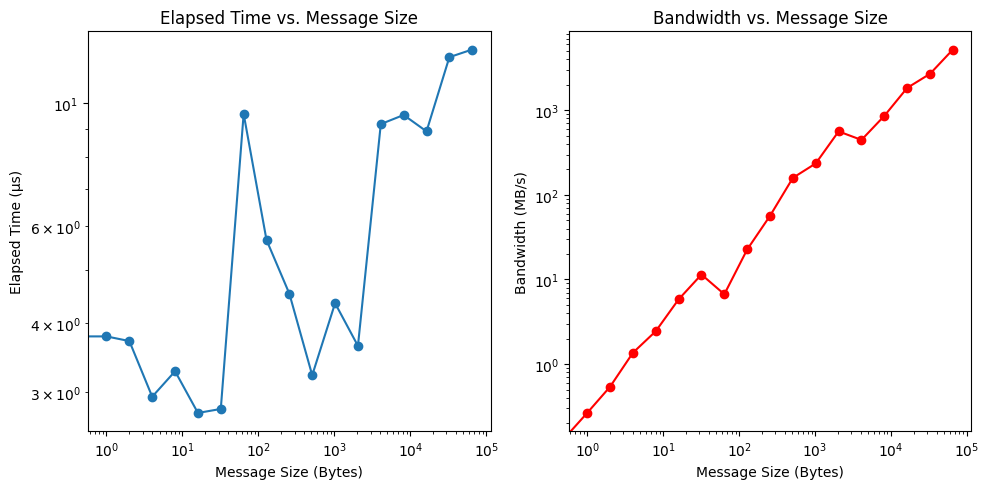

In [242]:
plt.figure(figsize=(10, 5))

# Plotting Time
plt.subplot(121)
plt.loglog(data['MessageSize(Bytes)'], data['TimePerMessage(µs)'], marker='o')
plt.xlabel('Message Size (Bytes)')
plt.ylabel('Elapsed Time (µs)')
plt.title('Elapsed Time vs. Message Size')

# Plotting Bandwidth
plt.subplot(122)
plt.loglog(data['MessageSize(Bytes)'], data['Bandwidth(MB/s)'], marker='o', color='red')
plt.xlabel('Message Size (Bytes)')
plt.ylabel('Bandwidth (MB/s)')
plt.title('Bandwidth vs. Message Size')

plt.tight_layout()
plt.show()

## 2) Cellular Automata 1-d

In [245]:
!mpicc CelluralAutomata1D.c -o cellural_automata

In [246]:
!mpirun -n 4 --allow-run-as-root --oversubscribe ./cellural_automata

Simulation took 0.005426 seconds
